# 📚 Marching Squares Exercise (8 Points)
**From Scalar Fields to 2D isosurfaces**  

## 1. Imports and Configuration

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Set global plot style
plt.style.use('seaborn-v0_8')
COLOR_MAP = 'viridis'

## 2. Implicit Field Library
### Core Fields (Pre-implemented)

In [2]:
def circle_field(x, y, radius=1.0):
    """
    Basic circular field
    Equation: x² + y² - radius² = 0
    
    Parameters:
    x, y (ndarray): Input grid coordinates
    radius (float): Circle radius
    """
    return x**2 + y**2 - radius**2

def metaballs_field(x, y, intensity=0.3):
    """
    Smooth metaball field with exponential potential
    Equation: Σ exp(-distance²) - intensity = 0
    
    Parameters:
    x, y (ndarray): Input grid coordinates
    intensity (float): Threshold for surface formation
    """
    d1 = np.exp(-5*((x-1)**2 + y**2))
    d2 = np.exp(-5*((x+1)**2 + y**2))
    return d1 + d2 - intensity

def superellipse_field(x, y, power=4, a=1, b=1):
    """
    Superellipse (Lamé curve)
    Equation: |x/a|ⁿ + |y/b|ⁿ - 1 = 0
    
    Parameters:
    x, y (ndarray): Input grid coordinates
    power (float): Exponent controlling shape
    a, b (float): Axes scaling factors
    """
    return (np.abs(x/a)**power + np.abs(y/b)**power) - 1

### Implementation Fields: Implement these fields following the provided equations (2 Points)
- **Exercise 1:** Implement the rectangle field and visualize
- **Exercise 2:** Implement a valid torus field
- **Exercise 3:** Implement the star field with adjustable points
- **Exercise 4:** Implement the sine wave field

In [3]:
def rectangle_field(x, y, width=1.5, height=1.0):
    """
    Signed Distance Field (SDF) for axis-aligned rectangle with corners at (width, height), (width, -height), (-width, -height), (-width, height)
    
    Parameters:
    x, y (ndarray): Input coordinates
    width (float): Half-width of rectangle (x-axis)
    height (float): Half-height of rectangle (y-axis)
    
    Returns:
    ndarray: Signed distance values where:
             - Positive values = outside rectangle
             - Negative values = inside rectangle
             - Zero = exactly on boundary
    """
    # Your code should start here ....
    axis_dist = np.array([np.abs(x) - width, np.abs(y) - height])

    # if x and y are outside the rectangle the following will be the axis distance, otherwise zero
    axis_dist_out = np.maximum(axis_dist, np.zeros_like(axis_dist))
    dist_out = np.linalg.norm(axis_dist_out,axis=0)

    # if x and y are inside the rectangle the following will be the distance to the closest side of the rectangle
    dist_in = np.minimum(np.maximum(axis_dist[0], axis_dist[1]), 0)
    return dist_in + dist_out 

def torus_field(x, y, R=1.2, r=0.4):
    """
    Torus (donut) field
    Equation: (√(x² + y²) - R)² - r² = 0
    
    Parameters:
    x, y (ndarray): Input grid coordinates
    R (float): Major radius (center to tube center)
    r (float): Minor radius (tube radius)
    """
    # Your code should start here ....
    xy = np.array([x,y])
    return (np.linalg.norm(xy, axis=0)-R)**2 - r**2

def star_field(x, y, points=5, amplitude=0.3):
    """
    N-pointed star field
    Equation: r - (1 + amplitude*cos(points·θ)) = 0
    
    Parameters:
    x, y (ndarray): Input grid coordinates
    points (int): Number of star points
    amplitude (float): Point sharpness (0-1)
    """
    theta = np.arctan2(y, x)
    # Your code should start here ....
    xy = np.array([x,y])
    radius = np.linalg.norm(xy, axis=0)
    return radius - (1 + amplitude*np.cos(points*theta))

def sine_wave_field(x, y, frequency=2, amplitude=0.5):
    """
    Vertical sine wave pattern where surface is actually just a line and there is no negative values
    Equation: y - amplitude·sin(frequency·x) = 0
    
    Parameters:
    x, y (ndarray): Input grid coordinates
    frequency (float): Wave oscillations per unit
    amplitude (float): Wave height
    """
    # Your code should start here ....
    return y-amplitude*np.sin(frequency*x)

## 3. Marching Squares Engine

### Implementation Fields   (6 Points)
- **Exercise 5:** Implement linear interpolation to determine surface & edge intersection

In [4]:
class MarchingSquares:
    """
    Marching Squares contour extractor
    
    Attributes:
    EDGE_TABLE (list): Case lookup table (16 configurations)
    res (int): Grid resolution (N x N cells)
    """
    
    # Lookup table format: [case][edge_pairs]
    EDGE_TABLE = [
        [],       # Case 0: 0000
        [[3,0]],  # Case 1: 0001
        [[0,1]],  # Case 2: 0010
        [[3,1]],  # Case 3: 0011
        [[1,2]],  # Case 4: 0100
        [[3,0], [1,2]],  # Case 5: 0101
        [[0,2]],  # Case 6: 0110
        [[3,2]],  # Case 7: 0111
        [[2,3]],  # Case 8: 1000
        [[0,2]],  # Case 9: 1001
        [[0,1], [2,3]],  # Case 10: 1010
        [[1,3]],  # Case 11: 1011
        [[1,3]],  # Case 12: 1100
        [[0,1]],  # Case 13: 1101
        [[0,3]],  # Case 14: 1110
        []        # Case 15: 1111
    ]

    def __init__(self, resolution=50):
        """
        Initialize marching squares grid
        
        Parameters:
        resolution (int): Number of grid points along each axis
        """
        self.res = resolution

    def interpolate(self, a, b, va, vb, x_coords, y_coords):
        """
        Linear interpolation between grid points
        
        Parameters:
        a, b (tuple): Grid indices of edge endpoints
        va, vb (float): Field values at a and b
        x_coords, y_coords (ndarray): Grid coordinate arrays
        
        Returns:
        tuple: Interpolated (x,y) coordinates
        """
        # Your code should start here ....
        # Calculate interpolated coordinates by calculating the slope and walking to zero along the correct axis and 
        # just the correct distance (1/slope times the value at a) and direction (-)
        # x is fixed, interpolation along y, along column by changing row
        if a[0] == b[0]:
            a_y = y_coords[a[1]]
            b_y = y_coords[b[1]]
            slope = (vb-va)/(b_y-a_y)
            intersection_y = a_y-va/slope
            intersection_x = x_coords[a[0]]
        # y is fixed, interpolation along x, along row by changing column
        elif a[1] == b[1]:
            a_x = x_coords[a[0]]
            b_x = x_coords[b[0]]
            slope = (vb-va)/(b_x-a_x)
            intersection_x = a_x-va/slope
            intersection_y = y_coords[a[1]]
        else:
            assert False, 'Interpolation should happen along fixed x or y values'

        return (intersection_x, intersection_y)

    def extract_contour(self, field_func, xlim=(-2,2), ylim=(-2,2)):
        """
        Main contour extraction routine
        
        Parameters:
        field_func (callable): Implicit field function
        xlim/ylim (tuple): Domain boundaries
        
        Returns:
        list: Line segments as [(x0,y0), (x1,y1)]
        """
        # Create computation grid
        x = np.linspace(xlim[0], xlim[1], self.res)
        y = np.linspace(ylim[0], ylim[1], self.res)
        X, Y = np.meshgrid(x, y)
        Z = field_func(X, Y)
        
        segments = []

        # Process each cell in grid
        for i in range(self.res - 1):  # x-axis iteration
            for j in range(self.res - 1):  # y-axis iteration
                # Get cell corner values (v0-v3: bottom-left clockwise)
                v = [
                    Z[j, i],     # v0: bottom-left
                    Z[j, i+1],   # v1: bottom-right
                    Z[j+1, i+1], # v2: top-right
                    Z[j+1, i]    # v3: top-left
                ]
                
                # Determine case index (4-bit binary number)
                case = sum(2**k for k, val in enumerate(v) if val >= 0)
                
                # Get edge pairs for current case
                for edge_pair in self.EDGE_TABLE[case]:
                    points = []
                    for edge in edge_pair:
                        # Determine edge endpoints
                        if edge == 0:   # Bottom edge
                            a, b = (i, j), (i+1, j)
                        elif edge == 1: # Right edge
                            a, b = (i+1, j), (i+1, j+1)
                        elif edge == 2: # Top edge
                            a, b = (i+1, j+1), (i, j+1)
                        else:          # Left edge (3)
                            a, b = (i, j+1), (i, j)
                        
                        # Calculate intersection point
                        points.append(self.interpolate(
                            a, b, Z[a[1], a[0]], Z[b[1], b[0]], x, y
                        ))
                    
                    # Store valid line segments
                    if len(points) == 2:
                        segments.append(points)
        
        return segments

## 4. Visualization System

In [5]:
def plot_contour_comparison(field_func, resolutions=[20, 40, 80]):
    """
    Visualize contour extraction at different resolutions
    
    Parameters:
    field_func (callable): Implicit field function
    resolutions (list): Grid resolutions to compare
    """
    plt.figure(figsize=(15, 5))
    
    # Create common grid for reference contour
    x_ref = np.linspace(-2, 2, 100)
    y_ref = np.linspace(-2, 2, 100)
    X_ref, Y_ref = np.meshgrid(x_ref, y_ref)
    Z_ref = field_func(X_ref, Y_ref)
    
    for idx, res in enumerate(resolutions, 1):
        ax = plt.subplot(1, 3, idx)
        
        # Plot field background
        ax.contourf(X_ref, Y_ref, Z_ref, levels=50, 
                   cmap=COLOR_MAP, alpha=0.3)
        
        # Extract and plot contour
        ms = MarchingSquares(res)
        segments = ms.extract_contour(field_func)
        for seg in segments:
            ax.plot([seg[0][0], seg[1][0]], 
                    [seg[0][1], seg[1][1]], 
                    'r-', linewidth=1.5)
        
        ax.set_title(f'Resolution: {res}x{res}')
        ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

## 5. Demonstration and Exercises

### Prebuilt Field Visualization

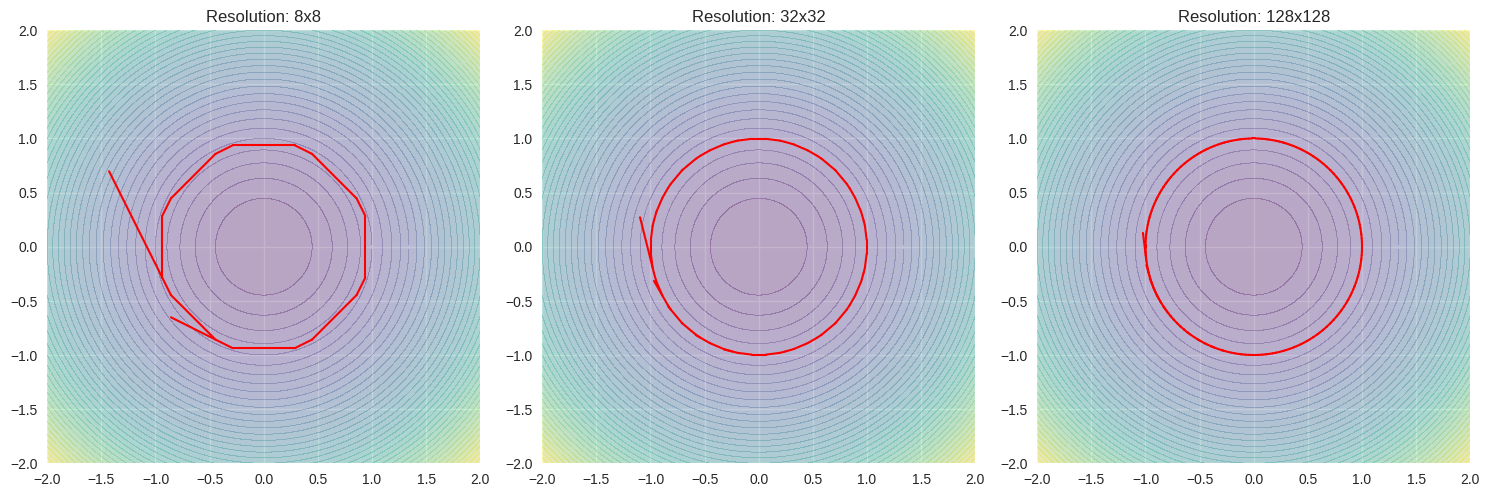

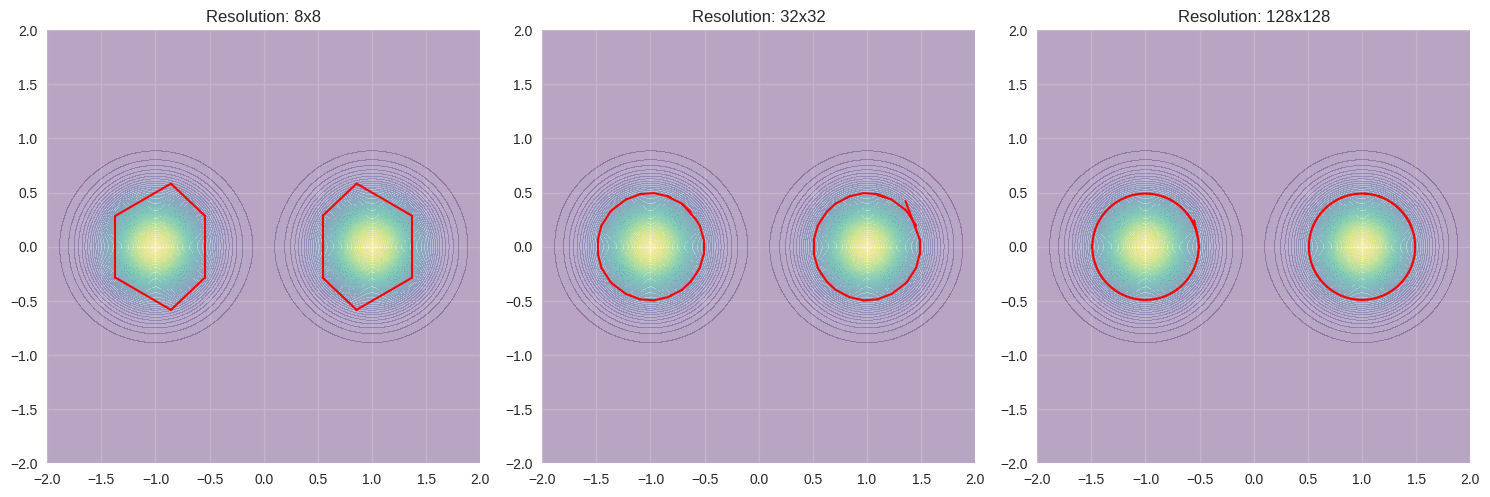

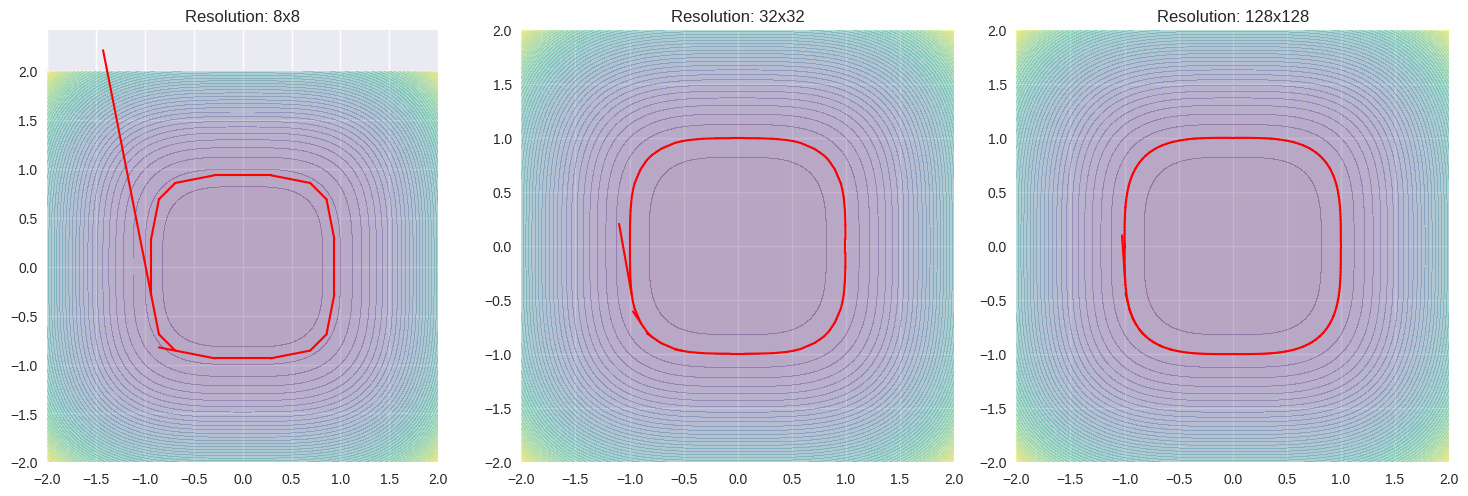

In [6]:
# Circle demonstration
plot_contour_comparison(circle_field, [8, 32, 128])

# Metaballs demonstration
plot_contour_comparison(metaballs_field, [8, 32, 128])

# Superellipse demonstration
plot_contour_comparison(lambda x,y: superellipse_field(x,y,3.5), [8, 32, 128])

### Student's Implementation Visualization

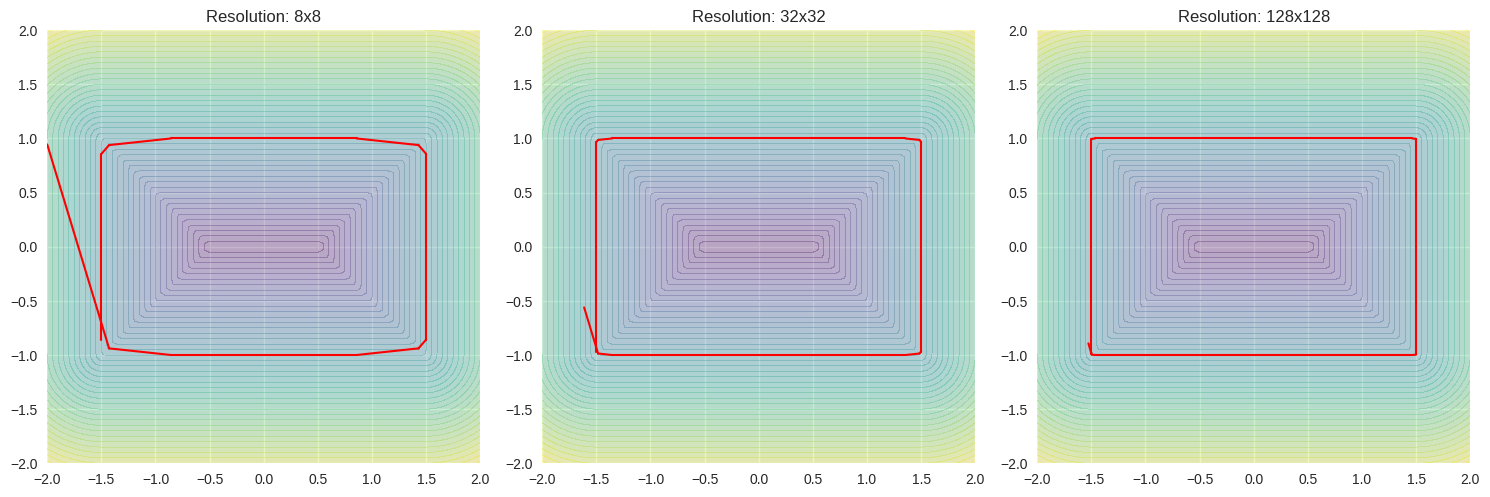

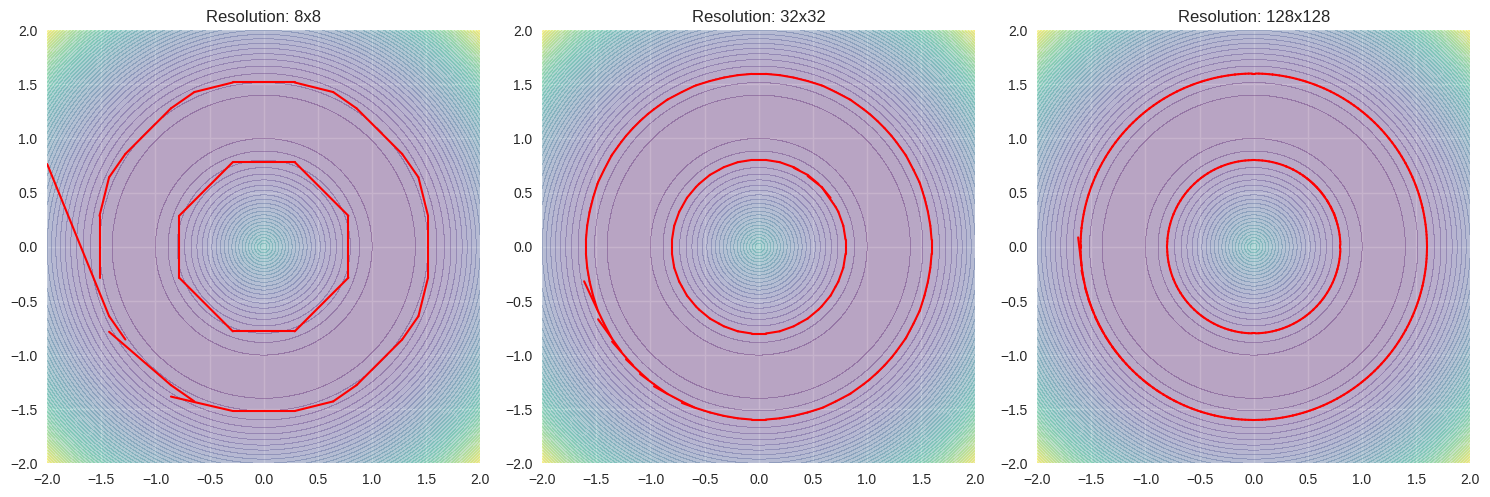

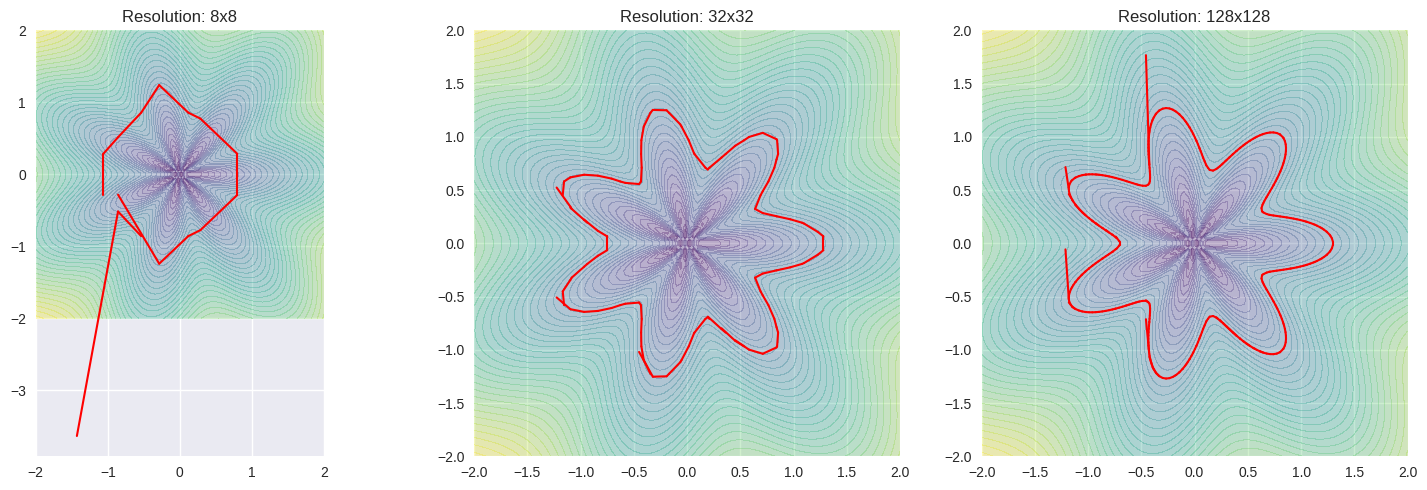

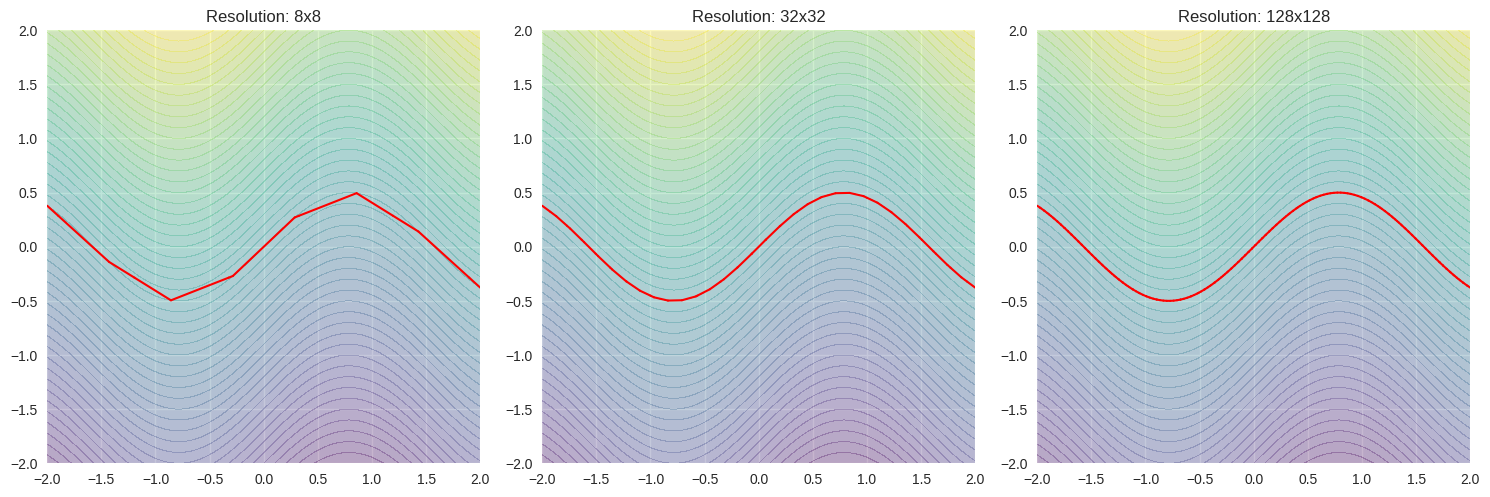

In [7]:
# Visualize rectangle_field first
plot_contour_comparison(rectangle_field, [8, 32, 128])

# Visualize torus_field
plot_contour_comparison(torus_field, [8, 32, 128])

# Visualize star_field
plot_contour_comparison(lambda x,y: star_field(x,y,points=7), [8, 32, 128])

# Implement sine wave field
plot_contour_comparison(lambda x,y: sine_wave_field(x, y, 
                        frequency=2, amplitude=0.5), [8, 32, 128])

**Expected Results**:<br>
![Rectangle](./../data/rect_ms.png)
![Circle](./../data/circle_ms.png)
![Star](./../data/star_ms.pngoutput.png)
![Sin](./../data/sin_ms.png)